In [1]:
import pandas as pd
import altair_ally as aly
import altair as alt
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
aly.alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


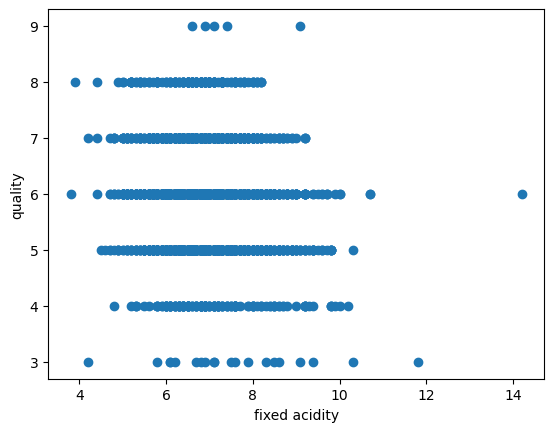

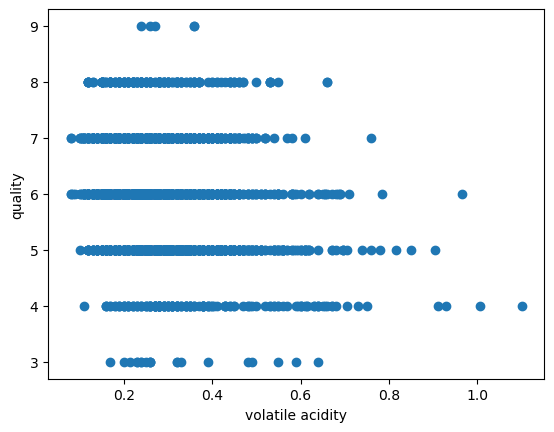

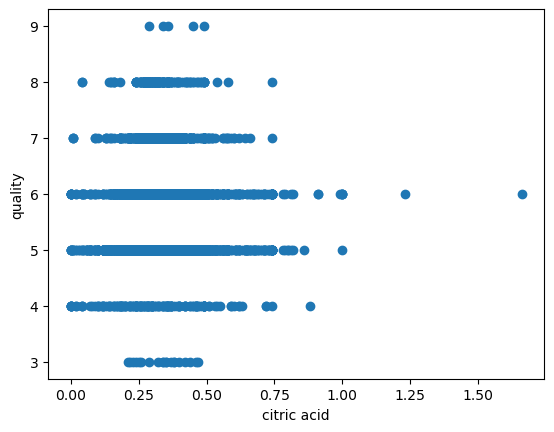

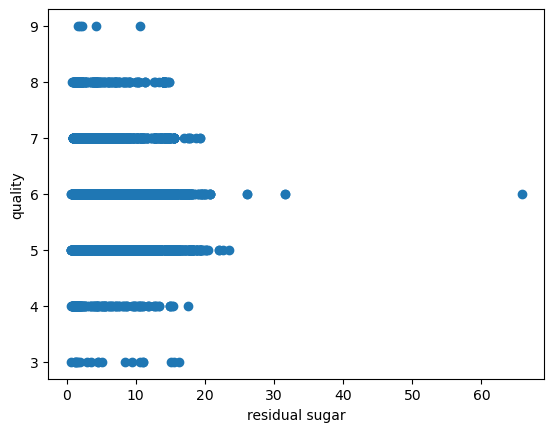

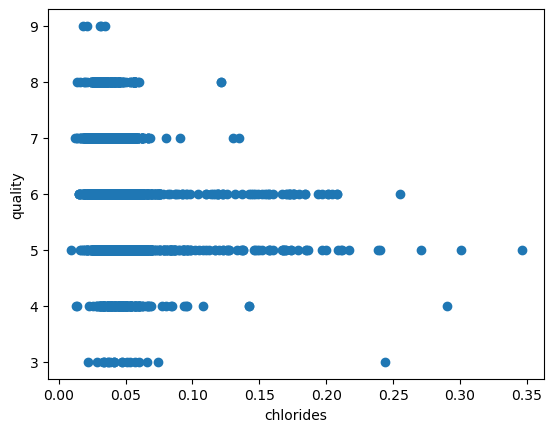

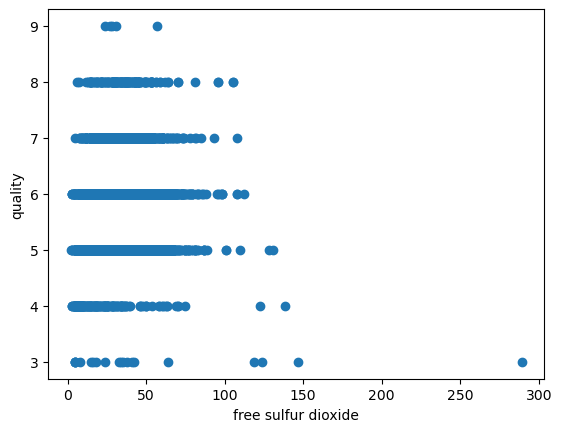

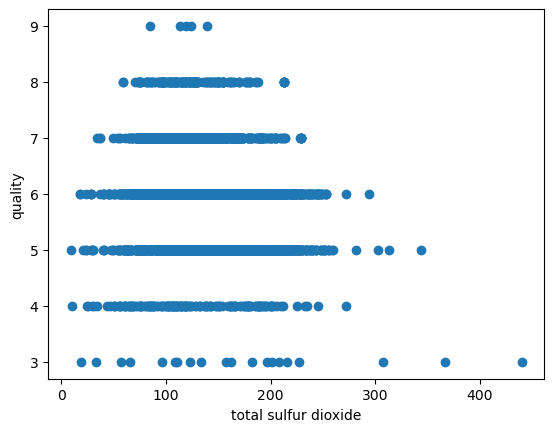

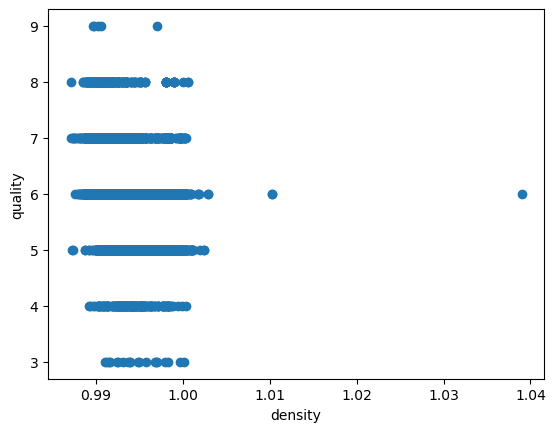

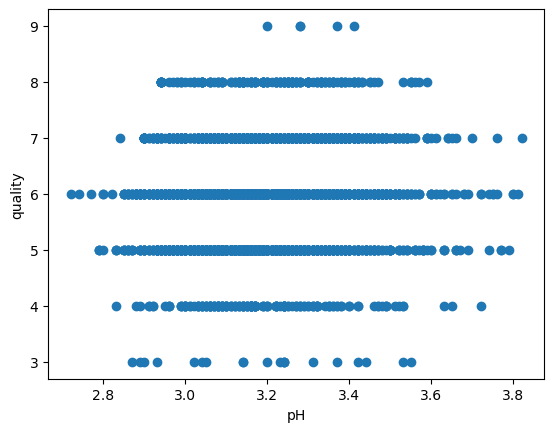

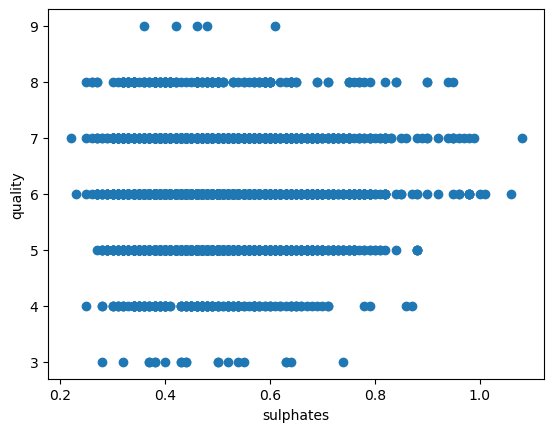

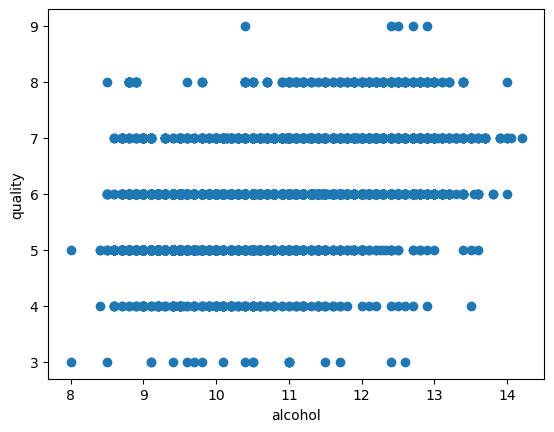

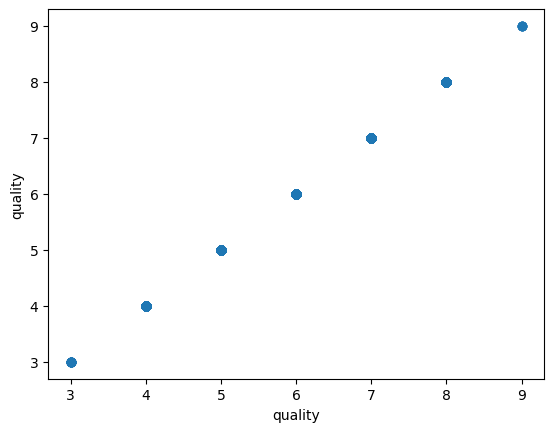

In [3]:
origin_df = pd.read_csv('data/winequality-white.csv', sep=';', encoding='utf-8')
print(origin_df['quality'].value_counts())

for i in origin_df.columns.tolist():
    feat = i
    plt.plot(origin_df[feat], origin_df['quality'], 'o')
    plt.xlabel(feat)
    plt.ylabel('quality')
    plt.show()


In [4]:
aly.corr(origin_df)

alt.ConcatChart(...)

In [5]:
origin_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [6]:
# separate the response and explanatory variables
X = origin_df.drop(columns=["quality"])
y = origin_df["quality"]

For exploratory purposes, we first create an ordinary least squares linear regression model including all predictors:

In [7]:
import statsmodels.formula.api as smf

model = smf.ols("y ~ X", data=origin_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     174.3
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:43:49   Log-Likelihood:                -5543.7
No. Observations:                4898   AIC:                         1.111e+04
Df Residuals:                    4886   BIC:                         1.119e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    150.1928     18.804      7.987      0.0

This model has an R-squared value of 0.282, meaning that the model explains roughly 28% of variability in the data. The R-squared value is close to that of the adjusted R-squared, suggesting most predictors contribute explanatory power to the model.  
The p-value of the F-statistics is small, indicating that at least one predictor has a statistically significant assocation with the response.  
The output reveals that the condition number of the model is large, possibly indicating strong multicollinearity. Thus, we will opt for a ridge regression to induce an L2 penalty on correlated variables.

In [8]:
numeric_features = X.columns
numeric_transformer = StandardScaler()

In [9]:
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", RidgeCV())
    ]
)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,None


In [11]:
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2: {r2:.3f}")

RMSE: 0.734
R^2: 0.300


In [12]:
linreg = model.named_steps["regressor"]
coef_df = pd.DataFrame(
    {"feature": X.columns, "coefficient": linreg.coef_}
).sort_values("coefficient", ascending=False)

coef_df

,feature,coefficient
3,residual sugar,0.378340
10,alcohol,0.260201
8,pH,0.089316
9,sulphates,0.076358
5,free sulfur dioxide,0.067991
0,fixed acidity,0.029480
4,chlorides,-0.002330
2,citric acid,-0.003946
6,total sulfur dioxide,-0.024003
1,volatile acidity,-0.187054


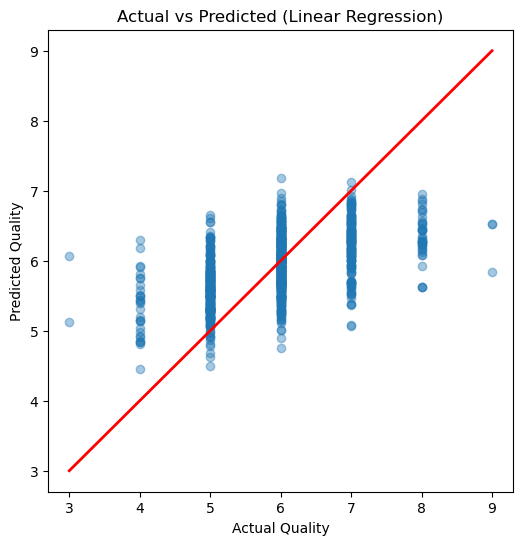

In [16]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linewidth=2, color='red')
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted (Linear Regression)")
plt.show()

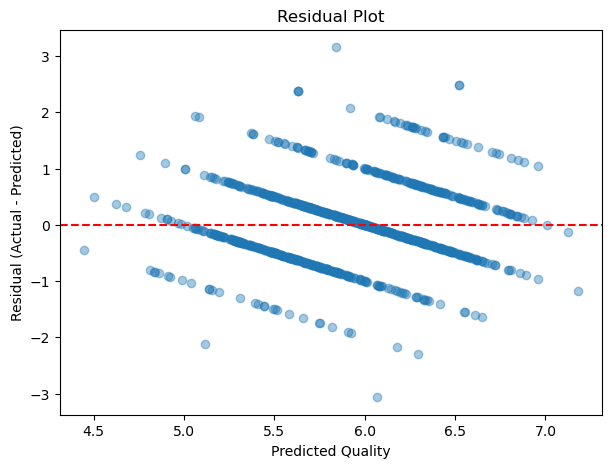

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Quality")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

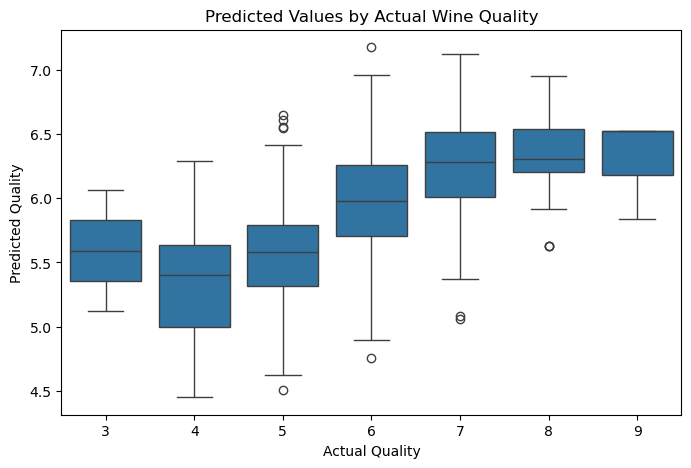

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df_viz = pd.DataFrame({
    "Actual Quality": y_test,
    "Predicted Quality": y_pred
})

plt.figure(figsize=(8,5))
sns.boxplot(x="Actual Quality", y="Predicted Quality", data=df_viz)
plt.title("Predicted Values by Actual Wine Quality")
plt.show()